# **TMA4215 - Project part 1**

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import sympy 
import pandas as pd
from scipy.special import factorial
import autograd.numpy as anp
from autograd import grad
import tqdm
from IPython.display import display

newparams = {'figure.figsize': (8.0, 6.0), 'axes.grid': True,
             'lines.markersize': 6, 'lines.linewidth': 1,
             'font.size': 10}
plt.rcParams.update(newparams)

___
## Task *a*

In [31]:
def lagrange_polys(x, xs, ys):
    """
    Evaluates the Lagrange interpolating polynomial as a symbolic expression in x.

    Parameters
    ----------
    x : sympy.Symbol
        The symbolic variable for the polynomial.
    xs : array-like
        The x-coordinates of the known data points.
    ys : array-like
        The y-coordinates of the known data points.

    Returns
    -------
    sympy.Expr
        The symbolic Lagrange interpolating polynomial in x.
    """
    n = len(xs)
    ls = [[reduce(lambda x,y:x*y, [(x - xs[j])/(xs[i] - xs[j]) for j in range(n) if j != i])] for i in range(n)]
    # reduces all the products using lambda function for every i when i!=j
    return reduce(lambda x,y:x+y, np.array(ys)@np.array(ls))
    # sums up all the products of y_i and l_i(x)

In [32]:
def lagrange_func(n, a, b, f, nodes_str='equidistant'):
    """
    Constructs the Lagrange interpolating polynomial as a callable function.

    Parameters
    ----------
    n : int
        The degree of the polynomial (number of nodes - 1).
    a : float
        The start of the interval.
    b : float
        The end of the interval.
    f : callable
        The function to interpolate.
    nodes : str, optional
        The type of nodes to use ('equidistant' or 'chebyshev'). Default is 'equidistant'.

    Returns
    -------
    tuple
        (nodes used, callable function)
    """
    if nodes_str not in ['equidistant', 'chebyshev']:
        raise ValueError("nodes must be 'equidistant' or 'chebyshev'")
    
    transform_nodes = lambda x: 0.5*(b-a)*x + 0.5*(a+b) # function to transform nodes from [-1,1] to [a,b]
    x = sympy.symbols('x') # symbolic variable using sympy


    if nodes_str == 'equidistant':
        nodes = np.linspace(-1, 1, n+1)
        eq_nodes = transform_nodes(nodes)
        y_eq = lagrange_polys(x, eq_nodes, f(eq_nodes))
        lagrange_eq_func = sympy.lambdify(x, y_eq, modules=['numpy'])
        return eq_nodes, lagrange_eq_func
    
    elif nodes_str == 'chebyshev':
        nodes = np.cos((2*np.arange(n+1)+1)/(2*n+2)*np.pi)
        cheb_nodes = transform_nodes(nodes)
        y_cheb = lagrange_polys(x, cheb_nodes, f(cheb_nodes))
        lagrange_cheb_func = sympy.lambdify(x, y_cheb, modules=['numpy'])
        return cheb_nodes, lagrange_cheb_func

I have choosen to use sumpy symbols instead of arrays as inputs to the lagrange_poly function and than make a callable lagrange polynomial. 

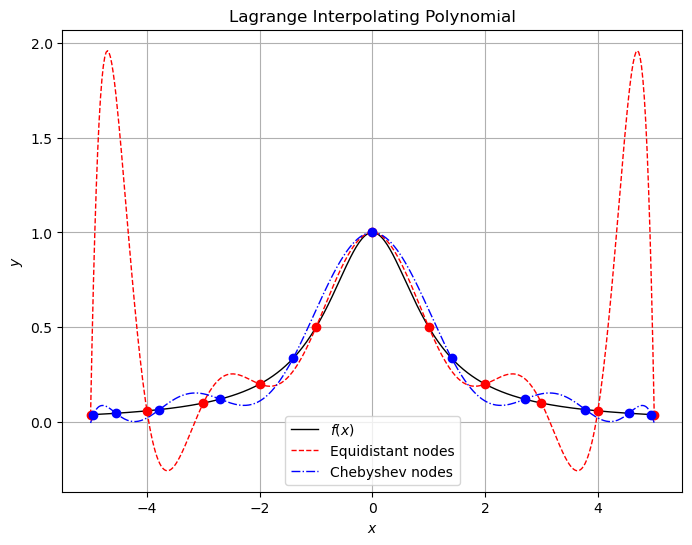

In [33]:
n = 10
a, b = -5, 5

f = lambda x: 1/(1+x**2) # Runge's function
xs = np.linspace(a, b, 400)
ys = f(xs)

eq_nodes, eq_func = lagrange_func(n, a, b, f, nodes_str='equidistant')
cheb_nodes, cheb_func = lagrange_func(n, a, b, f, nodes_str='chebyshev')

plt.plot(xs, ys, 'k-', label='$f(x)$')
plt.plot(xs, eq_func(xs), 'r--', label='Equidistant nodes')
plt.plot(xs, cheb_func(xs), 'b-.', label='Chebyshev nodes')
plt.plot(eq_nodes, f(eq_nodes), 'ro')
plt.plot(cheb_nodes, f(cheb_nodes), 'bo')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Lagrange Interpolating Polynomial')
plt.show()

The plot shows the Runge function, approximated by two lagrange interpolations polynomials. One with Chebyshev nodes and one with equidistant nodes. Chebyshev nodes results in a much smaller error on the edges of the function, than the equidistant nodes.

___
## Task *b*

In this task we consider the two functions
$$
f_1(x)=\cos(2\pi x),\quad x\in[0,1], 
$$
$$
f_2(x)=e^{3x}\sin(2x),\quad x\in[0,\pi/4].
$$

Let us first look at potential convergence for these functions in the $L^{\infty}$-norm and $L^{2}$-norm. Assume first $f\in C^{n+1}[a,b]$, let distinct nodes $x_0,\dots,x_n\in[a,b]$, and let $p_n$ be the degree-$n$ interpolating polynomial of $f$ at these nodes. Then for each $x\in[a,b]$ there exists $\xi=\xi(x)\in(a,b)$ such that
$$
f(x)-p_n(x)=\frac{f^{(n+1)}(\xi(x))}{(n+1)!}\,\prod_{j=0}^{n}(x-x_j).
$$
Define 
$$
\omega(x)=\prod_{j=0}^{n}(x-x_j),\quad M_{n+1}=\max_{\xi\in[a,b]}\bigl|f^{(n+1)}(\xi)\bigr|.
$$
Such that we can bound the error as
$$
\lVert f-p_n\rVert_{\infty} \le\ \frac{M_{n+1}}{(n+1)!}\,\max_{x\in[a,b]}\bigl|\omega(x)\bigr|.
$$
We also know that $ \lVert f-p_n\rVert_{L^2(a, b)} \le \sqrt{b-a}\lVert f-p_n\rVert_{\infty}$ so convergence in $L^{\infty}$-norm implies convergence in $L^2$-norm. Now let us find a bound for $M_{n+1}$.

For $f_1(x)=\cos(2\pi x)$ on the intervall $[0,1]$
$$
f_1^{(k)}(x) = (2\pi)^k \,\cos \Bigl(2\pi x+\frac{k\pi}{2}\Bigr)
\;\Rightarrow\;
|f_1^{(k)}(x)| \le (2\pi)^k.
$$
Such that 
$$
M_{n+1}=(2\pi)^{n+1} 
\;\Rightarrow\;
\lVert f_1-p_n \lVert_{\infty} \; \le \frac{(2\pi)^{n+1}}{(n+1)!} \, \max_{x\in[0,1]} \bigl|\omega(x)\bigr|.
$$

For $f_2(x)=e^{3x}\sin(2x)$ on the intervall $[0,\pi/4]$
$$
f_2(x)=\Im \bigl(e^{(3+2i)x}\bigr)
\;\Rightarrow\;
f_2^{(k)}(x)=\Im\bigl((3+2i)^k e^{(3+2i)x}\bigr)
\;\Rightarrow\;
| f_2^{(k)}(x) | \le e^{3x}\,|3+2i|^k=e^{3x}\,(\sqrt{13})^{\,k}.
$$

Maximizing over $x\in[0,\pi/4]$ yields $x=\pi/4$, hence
$$
M_{n+1} = e^{3\pi/4}\, (\sqrt{13})^{n+1}
\;\Rightarrow\;
\lVert f_2-p_n \Vert_\infty \le \frac{e^{3\pi/4}\, (\sqrt{13})^{n+1}}{(n+1)!} \, \max_{x\in[0,\pi/4]} \bigl|\omega(x)\bigr|.
$$

Now take the worst possible bound 
$$
\max_{x\in[a, b]} \bigl|\omega(x)\bigr| \le (b-a)^{n+1},
$$

such that

$$
\lVert f_1-p_n \lVert_{\infty} \; \le \frac{(2\pi)^{n+1}}{(n+1)!} \overset{n\rightarrow\infty}{\longrightarrow}0,
$$
$$
\lVert f_2-p_n \Vert_\infty \le \frac{e^{3\pi/4}\, (\sqrt{13})^{n+1}}{(n+1)!} \overset{n\rightarrow\infty}{\longrightarrow}0.
$$

This shows that interpolation for both the functions converge regardless of nodes, for both $L^{\infty}$-norm and $L^{2}$-norm. Furthermore, let us find a better bound for $\max_{x\in[0,1]} \bigl|\omega(x)\bigr|$. For chebyshev nodes on an intervall $[a, b]$, let 

$$
t_j=\cos \Bigl(\frac{2j+1}{2n+2}\pi\Bigr),\ j=0,\dots,n,
$$
$$
x_j=\frac{a+b}{2}+\frac{b-a}{2}\,t_j,
$$
Such that
$$
\max_{x\in[a,b]}|\omega(x)| = 2^{-n}\Bigl(\frac{b-a}{2}\Bigr)^{n+1}.
$$
In particular on $[0, 1]$
$$
\max_{x\in[0,1]}|\omega(x)| = 2^{-n}\Bigl(\frac{1}{2}\Bigr)^{n+1} = 2^{-(2n+1)}.
$$

For equidistant nodes on the intervall $[a, b]$ with nodes $x_i = a + ih, \; h = \frac{b - a}{n}, \; i= 0, \dots, n$ we get
$$
|\omega(x)| \le \frac{h^{n+1}}{4}n!
$$
such that
$$
\max_{x\in[0, 1]}|\omega(x)| = \frac{n!}{4 \, n^{n+1}}
$$
Resulting $L^{\infty}$ error bound for $f_1(x)=\cos(2 \pi x)$ on $[0, 1]$ given $M_{n+1}=(2\pi)^{n+1}$

$$
\lVert f-p_n\lVert_{\infty} \le \frac{(2\pi)^{n+1}}{(n+1)!}\ \max_{x\in[0,1]}|\omega(x)|.
$$

Chebyshev nodes on $[0,1]$
$$
\boxed{\displaystyle 
\lVert f-p_n\lVert_{\infty} \, \le \frac{\pi^{n+1}}{2^{n} (n+1)!}
}
$$
Equidistant nodes on $[0,1]$
$$
\boxed{\displaystyle 
\lVert f-p_n\lVert_{\infty} \, \le \frac{1}{4 (n+1)} \Bigl( \frac{2 \pi}{n} \Bigr) ^{n+1} 
}
$$




Furthermore, we estimate $\lVert f - p_n\rVert$, where $\lVert\cdot\rVert$ denotes either the max-norm ($L^\infty$) or the $L^2$-norm on $[a,b]$, for various values of $n$. We approximate these norms using a uniform evaluation grid $\{\eta_i\}_{i=0}^{N}$ on $[a,b]$ with step $h=(b-a)/N$ (we take $N=100\,n$, so there are $N{+}1$ sample points). The discrete estimates are
$$
\lVert f - p_n\rVert_{\infty}\ \approx\ \max_{0\le i\le N}\, \bigl|f(\eta_i)-p_n(\eta_i)\bigr|,
$$
$$
\lVert f - p_n\rVert_{2}\ \approx\ \Bigl(h\sum_{i=0}^{N} \bigl(f(\eta_i)-p_n(\eta_i)\bigr)^2\Bigr)^{1/2}
\ =\ \frac{\sqrt{b-a}}{\sqrt{N}}\,
\left(\sum_{i=0}^{N} \bigl(f(\eta_i)-p_n(\eta_i)\bigr)^2\right)^{1/2}.
$$

In [34]:
def error_lagrange(n, a, b, f, nodes_str):
    """
    Computes the maximum and L2 norm errors for the Lagrange interpolating polynomial.

    Parameters
    ----------
    n : int
        The degree of the Lagrange polynomial.
    a : float
        The start of the interval.
    b : float
        The end of the interval.
    f : callable
        The function to interpolate.

    Returns
    -------
    tuple
        A tuple containing:
        - err_max (float): The maximum norm error (L∞ norm).
        - err_2 (float): The L2 norm error.
    """
    N = 100*n
    _, pn = lagrange_func(n, a, b, f, nodes_str=nodes_str)
    xs = np.linspace(a, b, N)
    f_vals = f(xs)
    vals = pn(xs)
    err_max = np.max(np.abs(f_vals - vals)) # max norm error for Chebyshev nodes
    err_2 = np.sqrt((b-a)/N * np.sum((f_vals - vals)**2)) # L2 norm error for Chebyshev nodes
    return err_max, err_2

In [35]:
n_values = np.linspace(2, 26, 12, dtype=int) # n values to test

a, b = 0, 1 # interval
f_1 = lambda x: np.cos(2*np.pi*x) # function to interpolate
p = len(n_values)
errors_f1 = {"max_cheb": np.zeros(p), "L2_cheb": np.zeros(p), "max_eq": np.zeros(p), "L2_eq": np.zeros(p)}
for i, n in enumerate(tqdm.tqdm(n_values)): # tqdm for progress bar
    err_max_cheb, err_2_cheb = error_lagrange(n, a, b, f_1, nodes_str='chebyshev')
    err_max_eq, err_2_eq = error_lagrange(n, a, b, f_1, nodes_str='equidistant')
    errors_f1["max_cheb"][i] = err_max_cheb
    errors_f1["L2_cheb"][i] = err_2_cheb
    errors_f1["max_eq"][i] = err_max_eq
    errors_f1["L2_eq"][i] = err_2_eq

a, b = 0, np.pi/4 # interval
f_2 = lambda x: np.exp(3*x)*np.sin(2*np.pi*x) # function to interpolate
errors_f2 = {"max_cheb": np.zeros(p), "L2_cheb": np.zeros(p), "max_eq": np.zeros(p), "L2_eq": np.zeros(p)}
for i, n in enumerate(tqdm.tqdm(n_values)): # tqdm for progress bar
    err_max_cheb, err_2_cheb = error_lagrange(n, a, b, f_2, nodes_str='chebyshev')
    err_max_eq, err_2_eq = error_lagrange(n, a, b, f_2, nodes_str='equidistant')
    errors_f2["max_cheb"][i] = err_max_cheb
    errors_f2["L2_cheb"][i] = err_2_cheb
    errors_f2["max_eq"][i] = err_max_eq
    errors_f2["L2_eq"][i] = err_2_eq


100%|██████████| 12/12 [00:02<00:00,  4.68it/s]


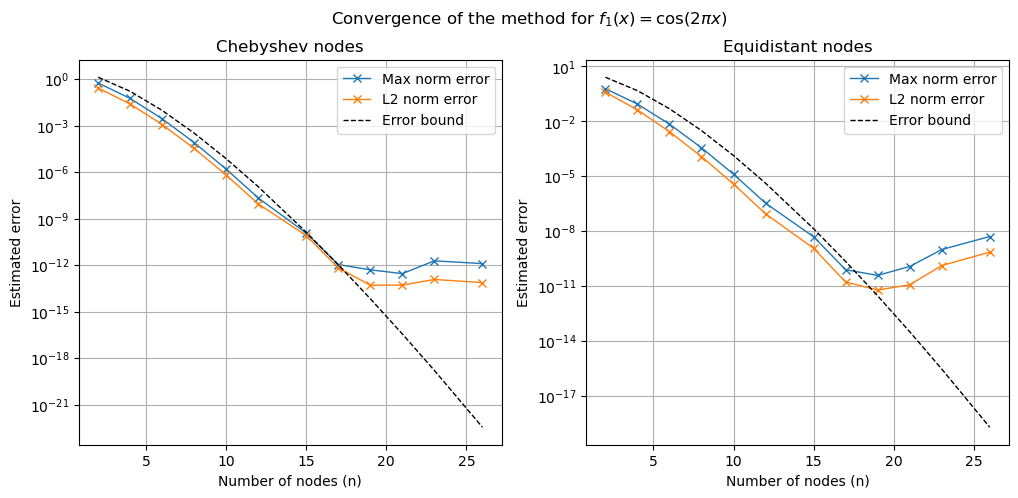

In [39]:
err_bnd = lambda n: np.pi**(n+1)/(2**(n)*factorial(n+1))
err_bnd_values = err_bnd(n_values)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].semilogy(n_values, errors_f1["max_cheb"], 'x-', label='Max norm error')
ax[0].semilogy(n_values, errors_f1["L2_cheb"], 'x-', label='L2 norm error')
ax[0].semilogy(n_values, err_bnd_values, 'k--', label='Error bound')
ax[0].set_title('Chebyshev nodes')
ax[0].set_xlabel('Number of nodes (n)')
ax[0].set_ylabel('Estimated error')
ax[0].legend()

err_bnd = lambda n: (2*np.pi / n)**(n + 1) / (4 * (n + 1))
err_bnd_values = err_bnd(n_values)
ax[1].semilogy(n_values, errors_f1["max_eq"], 'x-', label='Max norm error')
ax[1].semilogy(n_values, errors_f1["L2_eq"], 'x-', label='L2 norm error')
ax[1].semilogy(n_values, err_bnd_values, 'k--', label='Error bound')
ax[1].set_title('Equidistant nodes')
ax[1].set_xlabel('Number of nodes (n)')
ax[1].set_ylabel('Estimated error')
ax[1].legend()
fig.suptitle(r'Convergence of the method for $f_1(x) = \cos(2\pi x)$')
plt.grid(True)
plt.show()


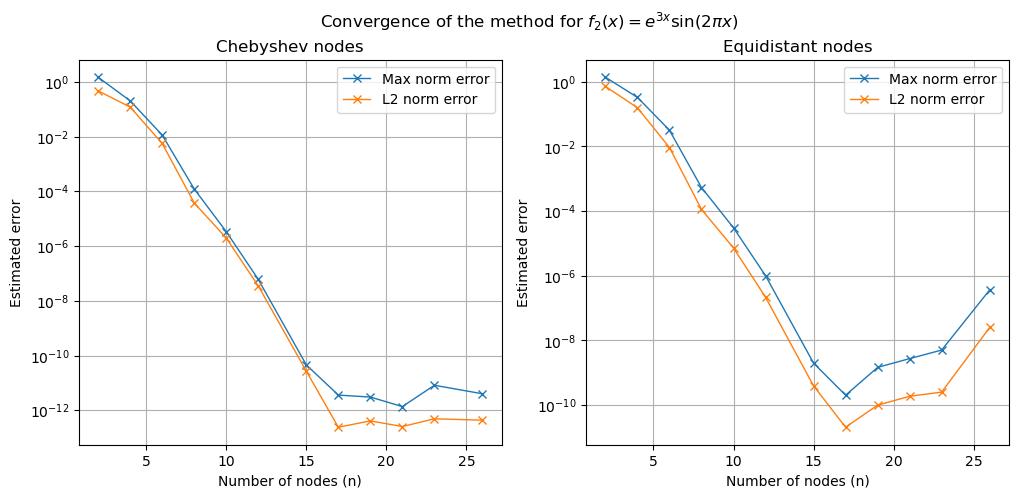

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].semilogy(n_values, errors_f2["max_cheb"], 'x-', label='Max norm error')
ax[0].semilogy(n_values, errors_f2["L2_cheb"], 'x-', label='L2 norm error')
ax[0].set_title('Chebyshev nodes')
ax[0].set_xlabel('Number of nodes (n)')
ax[0].set_ylabel('Estimated error')
ax[0].legend()

ax[1].semilogy(n_values, errors_f2["max_eq"], 'x-', label='Max norm error')
ax[1].semilogy(n_values, errors_f2["L2_eq"], 'x-', label='L2 norm error')
ax[1].set_title('Equidistant nodes')
ax[1].set_xlabel('Number of nodes (n)')
ax[1].set_ylabel('Estimated error')
ax[1].legend()
fig.suptitle(r'Convergence of the method for $f_2(x) = e^{3x} \sin(2\pi x)$')
plt.grid(True)
plt.show()

The figures show the empirical interpolation error in the $L^\infty$ and $L^2$ norms for $f_1(x)$ and $f_2(x)$ with both equidistant nodes and chebyshev nodes. The error decreases rapidly up to $n=17$ (reaching about $10^{-11}$). For larger $n$ the curves level off and may increase slightly. This saturation is caused by numerical effects: evaluating the Lagrange basis (or solving for coefficients) in double precision is ill-conditioned, so roundoff dominates the true approximation error. Thus the plateau reflects computational limits. Since the error is already below $10^{-11}$ by $n=17$, the interpolants have effectively converged at the plotted scales. For $f_1(x)$, the theoretical upper bound tracks the measured error closely up to $n=17$ for both choices of nodes, indicating that it is tight in this regime.

___
## Task *c*

Here we want to subdivide the interval $[a, b]$ in the disjoint union of $K$ subintervals $a = v_0 < v_1 < \dots < v_K = b$, and preform lagrange interpolation on $n + 1$ nodes on each subinterval $[v_i, v_{i+1}]$ with equidistant nodes.

In [9]:
def splines(K, n, a, b, f):
    """
    Constructs a list of Lagrange interpolating polynomials for subintervals.

    Parameters
    ----------
    K : int
        The number of subintervals to divide the interval [a, b].
    n : int
        The degree of the Lagrange polynomial for each subinterval.
    a : float
        The start of the interval.
    b : float
        The end of the interval.
    f : callable
        The function to interpolate.

    Returns
    -------
    list
        A list of tuples, where each tuple contains:
        - A tuple representing the subinterval (x0, x1).
        - A callable function representing the Lagrange polynomial for the subinterval.
    """
    vi = np.linspace(a, b, K+1)
    result = []
    for i in range(K):
        _, pn = lagrange_func(n, vi[i], vi[i+1], f, nodes_str='equidistant')
        result.append(((vi[i], vi[i+1]), pn))
    return result

In [10]:
def error_splines(K, n, a, b, f, N):
    """
    Computes the maximum norm error for spline interpolation.

    Parameters
    ----------
    K : int
        The number of subintervals to divide the interval [a, b].
    n : int
        The degree of the Lagrange polynomial for each subinterval.
    a : float
        The start of the interval.
    b : float
        The end of the interval.
    f : callable
        The function to interpolate.
    N : int
        The number of evaluation points in the interval [a, b].

    Returns
    -------
    float
        The maximum norm error between the true function values and the spline interpolation.
    """
    spl = splines(K, n, a, b, f)
    xs = np.linspace(a, b, N)
    f_vals = f(xs)
    spline_vals = np.zeros_like(xs)
    for k, ((x0, x1), pn) in enumerate(spl):
        left_ok  = (xs >= x0) if k == 0 else (xs >  x0)
        right_ok = (xs <= x1) if k == len(spl)-1 else (xs <  x1)
        mask = left_ok & right_ok
        spline_vals[mask] = pn(xs[mask]) # evaluate polynomial on its subinterval
    err_max = np.max(np.abs(f_vals - spline_vals)) # max norm error
    return err_max

100%|██████████| 10/10 [00:19<00:00,  1.90s/it]


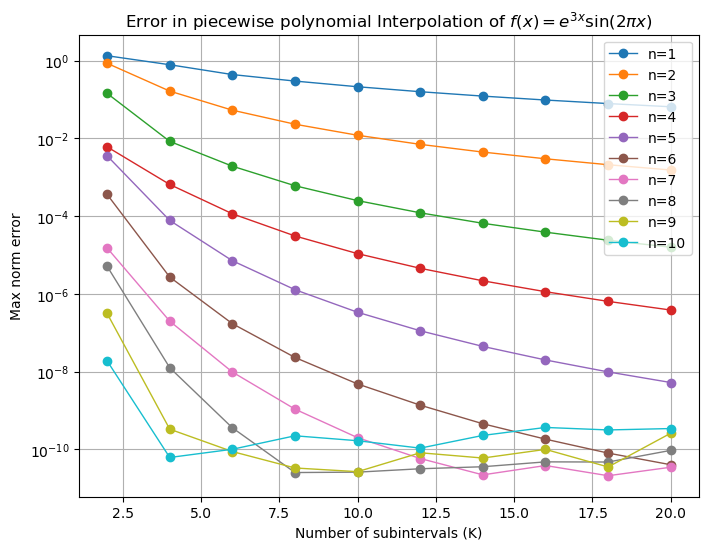

In [44]:
a, b = 0, np.pi/4
f = lambda x: np.exp(3*x)*np.sin(2*np.pi*x)
K_values = range(2, 22, 2)

for n in tqdm.tqdm(range(1, 11)):
    errs = []
    for K in K_values:
        errs.append(error_splines(K, n, a, b, f, K*n*10))

    errs = np.array(errs)
    plt.semilogy(K_values, errs, 'o-' , label=f'n={n}')
    
plt.xlabel('Number of subintervals (K)')
plt.ylabel('Max norm error')
plt.title(r'Error in piecewise polynomial Interpolation of $f(x) = e^{3x} \sin(2\pi x)$')
plt.grid(True)
plt.legend()
plt.show()

We se that as $K$ increases, the error approches 0.

We see that the error for piecewise interpolation polynomials reaches $10^{-10}$ with polynomial of degree $10$ per with $5$ subintervals. That is $(K + 1) \cdot (n + 1) = 66$ total nodes. Where as a single polynomial of degree $15$ reaches the same error. So it would seem that for simple functions like $ f(x) = e^{3x}\sin(2x)$ on the intervall $[0,\pi/4]$ a single polynomial converges faster that the piecewise polynomial. In other words, the piecewise polynomail is much more computationally expensive in this case.


100%|██████████| 10/10 [00:19<00:00,  2.00s/it]


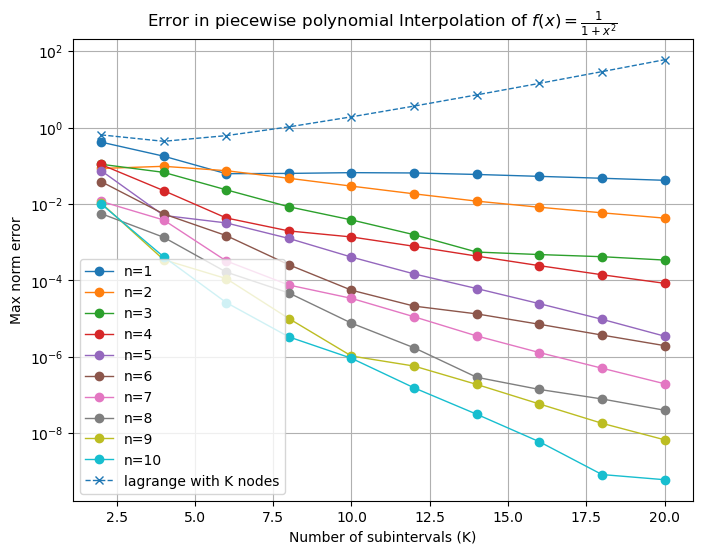

In [48]:
a, b = -5, 5 # interval
f = lambda x: 1 / (1 + x**2) # Runge's function
K_values = range(2, 22, 2)

for n in tqdm.tqdm(range(1, 11)):
    errs = []
    for K in K_values:
        errs.append(error_splines(K, n, a, b, f, K*n*10))

    errs = np.array(errs)
    plt.semilogy(K_values, errs, 'o-' , label=f'n={n}')

errs = []
for K in K_values:
    err, _ = error_lagrange(K, a, b, f, nodes_str='equidistant')
    errs.append(err)
    
errs = np.array(errs)
plt.semilogy(K_values, errs, 'x--' , label=f'lagrange with K nodes')

plt.xlabel('Number of subintervals (K)')
plt.ylabel('Max norm error')
plt.title(r'Error in piecewise polynomial Interpolation of $f(x) = \frac{1}{1+x^2}$')
plt.grid(True)
plt.legend()
plt.show()

However, on the more complex function $f(x) = \frac {1}{1+x^2}$ we see that the piecewise interpolation polynomials converge, for a sufficient n, around $n=6$. Where as the normal lagrange interpolation polynomial excperiences Runges phenomenon and diverges. This suggest that piecewise polynomials are well suited to handle more complicated functions. *Note* that the error for the lagrange polynomial is plotted with $n=K$ nodes, but we can se divergence allready for $n=20$.

100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


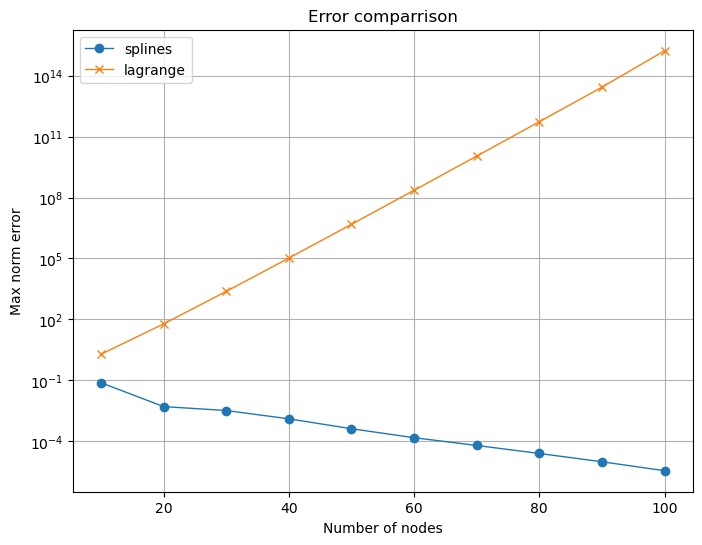

In [49]:
a, b = -5, 5 # interval
f = lambda x: 1 / (1 + x**2) # Runge's function

n = 5
errs_splines = []
errs_lagrange = []
for K in tqdm.tqdm(K_values):
    errs_splines.append(error_splines(K, n, a, b, f, K*n*100))
    err, _ = error_lagrange(K*n, a, b, f, nodes_str='equidistant')
    errs_lagrange.append(err)

errs_splines = np.array(errs_splines)
errs_lagrange = np.array(errs_lagrange)
K_values = np.array(K_values)
plt.semilogy(K_values*n, errs_splines, 'o-' , label=f'splines')
plt.semilogy(K_values*n, errs_lagrange, 'x-' , label=f'lagrange')


plt.xlabel('Number of nodes')
plt.ylabel('Max norm error')
plt.title(r'Error comparrison')
plt.legend()
plt.grid(True)
plt.show()

Here the $x$ axis is the number of nodes, not subintervals, and we see how poorly the normal interpolation poynimial preforms compared to the piecewise polynomial.

___
## Task *d*

We will now approximate $f$ using this radial basis funciton (RBF)

$$
f(x) \approx \tilde{f}(x) = \sum_{i=0}^{n} w_i\, \phi\!\left(|x - x_i|\right),
\qquad
\phi(r) = \exp\!\left(-(\varepsilon r)^2\right).
$$

Impose interpolation conditions
$$
\tilde{f}(x_i) = f(x_i), \quad i = 0,\dots,n,
$$
and solve 
$$
M \bold{w} = \bold{f},
$$
where $\bold{w} = [w_0,\dots,w_i]^T, \bold{f} = [f(x_0), \dots,f(x_n)]^T$, and $M$ is an $(n+1) \times (n+1)$ matrix with enteries
$$
M_{i,j} = \phi ( |x_i-x_j|).
$$

In [14]:
def RBF(nodes, ys, epsilon):
    """
    Constructs a Radial Basis Function (RBF) interpolator.

    Parameters
    ----------
    nodes : numpy.ndarray
        The array of nodes (x-coordinates) where the function is sampled.
    ys : numpy.ndarray
        The array of function values (y-coordinates) at the given nodes.
    epsilon : float
        The shape parameter for the RBF kernel.

    Returns
    -------
    callable
        A function that evaluates the RBF interpolant at given x-coordinates.

    Notes
    -----
    The RBF kernel used is Gaussian:
        phi(r) = exp(-(epsilon * r)^2)
    where r is the distance between points.
    """
    
    diffs = nodes[:, None] - nodes[None, :]
    K = anp.exp(-(epsilon * anp.abs(diffs))**2)
    omega = anp.linalg.solve(K, ys)
    def eval_at(x):  
        Phi = anp.exp(-(epsilon * anp.abs(x[:, None] - nodes[None, :]))**2)
        return anp.dot(Phi, omega)
    return eval_at


In [15]:
def error_RBF(n, a, b, f, nodes=None, epsilon=None):
    """
    Computes the maximum norm error for Radial Basis Function (RBF) interpolation.

    Parameters
    ----------
    n : int
        The number of nodes to use for interpolation.
    a : float
        The start of the interval.
    b : float
        The end of the interval.
    f : callable
        The function to interpolate.

    Returns
    -------
    float
        The maximum norm error between the true function values and the RBF interpolation.
    """
    if nodes is None:
        nodes = np.linspace(a, b, n+1)
    if epsilon is None:
        epsilon = 0.2 / abs(nodes[0] - nodes[1]) # shape parameter
    eval_function = RBF(nodes, f(nodes), epsilon)
    xs = np.linspace(a, b, 100*n)
    f_vals = f(xs)
    vals = eval_function(xs)
    return np.max(np.abs(f_vals - vals))

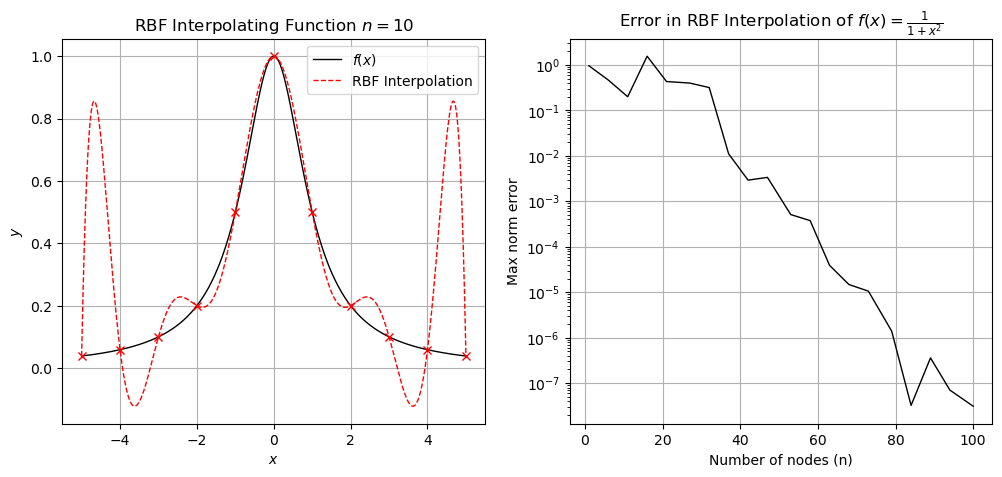

In [16]:
n = 10
a, b = -5, 5
f = lambda x: 1/(1+x**2) # Runge's function

nodes = np.linspace(a, b, n+1)

epsilon = 0.2 / abs(nodes[0] - nodes[1]) # shape parameter
eval_function = RBF(nodes, f(nodes), epsilon)
eval_nodes = np.linspace(a, b, 100*n)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(eval_nodes, f(eval_nodes), 'k-', label='$f(x)$')
ax[0].plot(eval_nodes, eval_function(eval_nodes), 'r--', label='RBF Interpolation')
ax[0].plot(nodes, f(nodes), 'rx')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')
ax[0].set_title(r'RBF Interpolating Function $n=10$')
ax[0].legend()

N = 20
n_values = np.linspace(1, 100, N, dtype=int)
errs = np.zeros(N)
for i, n in enumerate(n_values):
    errs[i] = error_RBF(n, a, b, f)
ax[1].semilogy(n_values, errs, 'k-')
ax[1].set_xlabel('Number of nodes (n)')
ax[1].set_ylabel('Max norm error')
ax[1].set_title(r'Error in RBF Interpolation of $f(x) = \frac{1}{1+x^2}$')
ax[1].grid(True)
plt.show()


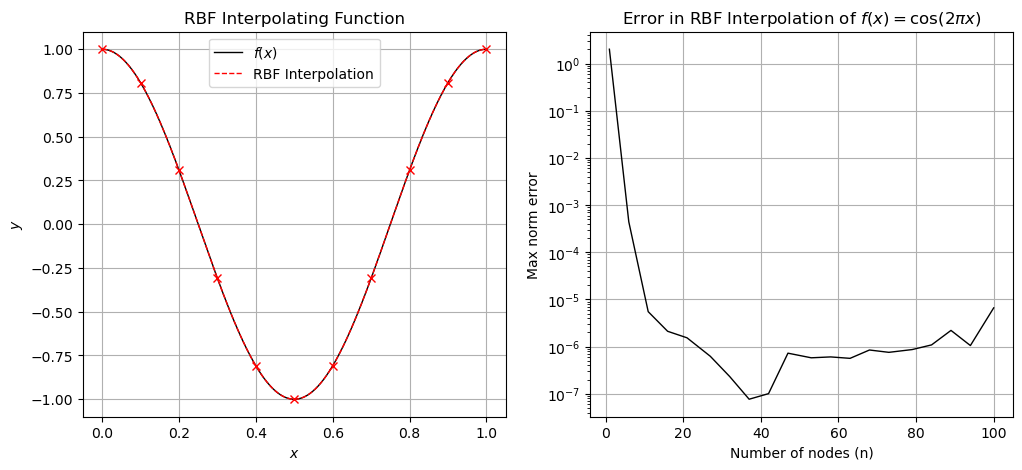

In [17]:
n = 10
a, b = 0, 1
f = lambda x: np.cos(2*np.pi*x) # Runge's function

nodes = np.linspace(a, b, n+1)

epsilon = 0.2 / abs(nodes[0] - nodes[1]) # shape parameter
eval_function = RBF(nodes, f(nodes), epsilon)
eval_nodes = np.linspace(a, b, 100*n)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(eval_nodes, f(eval_nodes), 'k-', label='$f(x)$')
ax[0].plot(eval_nodes, eval_function(eval_nodes), 'r--', label='RBF Interpolation')
ax[0].plot(nodes, f(nodes), 'rx')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')
ax[0].set_title(r'RBF Interpolating Function')
ax[0].legend()

N = 20
n_values = np.linspace(1, 100, N, dtype=int)
errs = np.zeros(N)
for i, n in enumerate(n_values):
    errs[i] = error_RBF(n, a, b, f)
ax[1].semilogy(n_values, errs, 'k-')
ax[1].set_xlabel('Number of nodes (n)')
ax[1].set_ylabel('Max norm error')
ax[1].set_title(r'Error in RBF Interpolation of $f(x) = \cos(2\pi x)$')
ax[1].grid(True)
plt.show()

The plots show the funciton approximations using the RBF and the error in $L^\infty$-norm. I let the shape parameter be $\frac{0.2}{|x_0-x_1|}$. This worked great for the simple function $\cos (2 \pi x)$. However for the function $\frac{1}{1+x^2}$ the error was quite large for small $n$, but got smaller with bigger $n$. Overall the RBF polynomial converges in these cases.

___
## Task *e*

Here we want to solve the following optimization problem
$$
\min_{\substack{x_0,\dots,x_n \in [a,b] \\ \varepsilon>0}}
\ \frac{b-a}{N}\sum_{k=0}^{N}\!\bigl(f(\eta_k)-\tilde{f}(\eta_k)\bigr)^2
\quad\text{subject to}\quad
\tilde{f}(x_j)=f(x_j),\ j=0,\dots,n.
$$



It is solved using a gradient decent based algorithm, with cost function
$$
\mathcal{C}([\mathbf{x},\varepsilon]) \;:=\; \frac{b-a}{N}\sum_{k=0}^{N}\!\bigl(f(\eta_k)-\tilde{f}(\eta_k)\bigr)^2,
\qquad
\tilde{f}(\eta) \;=\; \sum_{i=0}^{n} w_i\,\phi\!\left(|\eta-x_i|\right),\quad
\phi(r)=\exp\!\bigl(-(\varepsilon r)^2\bigr).
$$

$$
\mathbf{w} = \mathbf{M}^{-1}\mathbf{f},
\qquad
\mathbf{w}=[w_0,\dots,w_n]^{\mathsf{T}},
\qquad
\mathbf{f}=[f(x_0),\dots,f(x_n)]^{\mathsf{T}},
\qquad
M_{ij}=\phi\!\left(|x_i-x_j|\right).
$$

In [50]:
def _pack(nodes, s_logeps):
    return anp.concatenate([anp.array(nodes, dtype=float), anp.array([s_logeps])])

def _unpack(z):
    return z[:-1], z[-1]

class history:
    def __init__(self):
        self.iteration = []
        self.cost = []
        self.grad_norm = []
        self.L = []
        self.step = []
    
    def append(self, iteration, cost, grad_norm, L, step):
        self.iteration.append(iteration)
        self.cost.append(cost)
        self.grad_norm.append(grad_norm)
        self.L.append(L)
        self.step.append(step)
    
    def update(self, iteration, cost, grad_norm, L, step):
        self.iteration[-1] = iteration
        self.cost[-1] = cost
        self.grad_norm[-1] = grad_norm
        self.L[-1] = L
        self.step[-1] = step
        
    def to_dict(self):
        return {
            "iteration": self.iteration,
            "cost": self.cost,
            "grad_norm": self.grad_norm,
            "L": self.L,
            "step": self.step
        }

    def to_array(self):
        return anp.array([self.iteration, self.cost, self.grad_norm, self.L, self.step]).T

In [51]:
def make_cost(eta_x, eta_f, a, b, N):
    """
    Constructs the cost function for Radial Basis Function (RBF) interpolation.

    Parameters
    ----------
    eta_x : numpy.ndarray
        The evaluation points (x-coordinates) for the cost function.
    eta_f : numpy.ndarray
        The true function values (y-coordinates) at the evaluation points.
    a : float
        The start of the interval.
    b : float
        The end of the interval.
    N : int
        The number of evaluation points in the interval [a, b].

    Returns
    -------
    callable
        A function C(z) that computes the cost for a given set of nodes and the shape parameter.
        The input z is a concatenated array of nodes and the logarithm of the shape parameter.
    # """
    h = (b - a) / N
    def C(z):
        nodes, s = z[:-1], z[-1]
        eps = anp.exp(s)
        ys = f(nodes)
        pred = RBF(nodes, ys, eps)(eta_x)
        r = eta_f - pred
        return h * anp.sum(r**2)
    return C

In [52]:
def gd_backtracking(C, gradC, x0, L0=1.0, rho_bar=2.0, rho=0.5,
                    max_iter=400, inner_max=50, tol_grad=1e-7, tol_step=0.0):
    """
    Implements gradient descent with backtracking line search.

    Parameters
    ----------
    C : callable
        The cost function to minimize.
    gradC : callable
        The gradient of the cost function.
    x0 : array-like
        The initial guess for the optimization variables.
    L0 : float, optional
        The initial value of the Lipschitz constant. Default is 1.0.
    rho_bar : float, optional
        The factor by which to increase the Lipschitz constant during backtracking. Default is 2.0.
    rho : float, optional
        The factor by which to decrease the Lipschitz constant after a successful step. Default is 0.5.
    max_iter : int, optional
        The maximum number of iterations for the gradient descent. Default is 400.
    inner_max : int, optional
        The maximum number of backtracking steps per iteration. Default is 50.
    tol_grad : float, optional
        The tolerance for the gradient infinity norm to stop the optimization. Default is 1e-7.
    tol_step : float, optional
        The tolerance for the step size to stop the optimization. Default is 0.0.

    Returns
    -------
    tuple
        A tuple containing:
        - x (numpy.ndarray): The optimized variables.
        - phi (float): The final value of the cost function.
        - history (dictionary): A dictionary containing the optimization history with keys:
            "iteration", "cost", "grad_norm", "L", "step".
    """
    
    x = np.asarray(x0, dtype=float)
    L = L0

    phi = C(x)
    hist = history()

    for k in range(max_iter):
        g = np.asarray(gradC(x))
        gnorm = np.max(np.abs(g))

        hist.append(k, phi, gnorm, L, 0.0)
        if gnorm <= tol_grad:
            break

        accepted = False
        for _ in range(inner_max):
            step = 1.0 / L
            x_tilde = x - step * g
            dx = x_tilde - x

            phi_tilde = C(x_tilde)
            quad_upper = phi + np.dot(g, dx) + 0.5 * L * np.dot(dx, dx)

            if phi_tilde <= quad_upper:           # accept
                x, phi = x_tilde, phi_tilde
                L = rho * L
                hist.update(k, phi, gnorm, L, np.linalg.norm(dx))
                accepted = True
                break
            else:                                   # reject
                L = rho_bar * L

        if accepted and tol_step > 0.0 and hist.to_array()[-1][4] <= tol_step:
            break

    return x, phi, hist.to_dict()


In [22]:
n = 10
a, b = -5, 5
N = 100 * n
f = lambda x: 1/(1+x**2)
eta_x = anp.linspace(a, b, N + 1)    # Grid for cost evaluation
eta_f = f(eta_x)                     # Function values on the grid


nodes0 = anp.linspace(a, b, n + 1)   # Initial equidistant nodes
s0 = anp.log(1.0)                    # Initial log(epsilon)
theta0 = _pack(nodes0, s0) 


C = make_cost(eta_x, eta_f, a, b, N) # Cost function
gradC = grad(C)                      # Function for computing the gradient of the cost function

theta_star, phi_star, hist = gd_backtracking(C, gradC, theta0, L0=1.0, rho_bar=2.0, rho=0.5,
                                            max_iter=400, inner_max=50, tol_grad=1e-7)


nodes_star, s_star = _unpack(theta_star)
epsilon_star = float(anp.exp(s_star))

2.976194792795934e-06


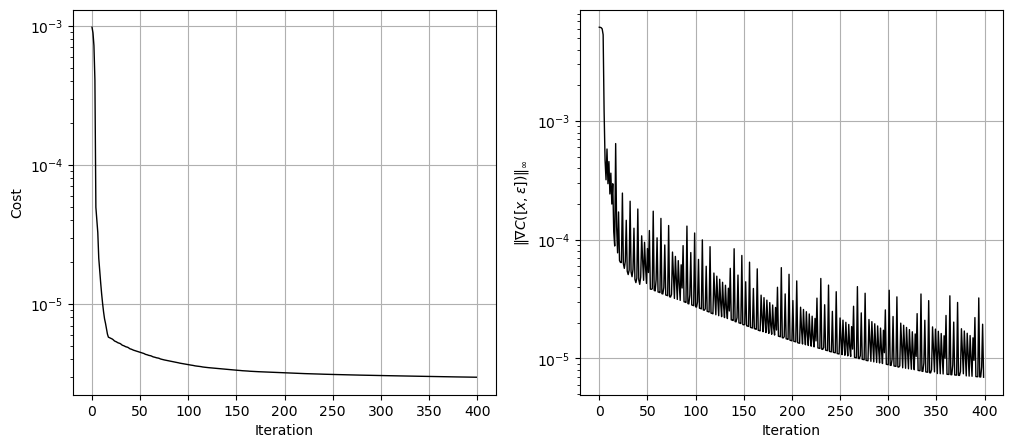

In [61]:
print(hist['cost'][-1])
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].semilogy(hist["iteration"], hist["cost"], 'k-')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Cost')
ax[1].semilogy(hist["iteration"], hist["grad_norm"], 'k-')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel(r'$\|\nabla C([x, \epsilon])\|_\infty$')

plt.show()


Here we can observe the cost quickly decreasing for the first few iterations, for so to level off until the max iterations are reached. The final cost is $2.97 \cdot 10^{-6} $. We also see that the Gradient of the cost function approaches 0.

In [80]:
import pandas as pd

n_values = np.linspace(2, 50, 10, dtype=int)
a, b = -5, 5
f = lambda x: 1/(1+x**2)
errs_eq = np.zeros(len(n_values))
errs_cheb = np.zeros(len(n_values))
errs_rbf = np.zeros(len(n_values))

for i, n in enumerate(tqdm.tqdm(n_values)):
    errs_eq[i] = error_lagrange(n, a, b, f, nodes_str='equidistant')[1]
    errs_cheb[i] = error_lagrange(n, a, b, f, nodes_str='chebyshev')[1]

    N = 100 * n
    nodes0 = anp.linspace(a, b, n + 1)   # Initial equidistant nodes
    eta_x = anp.linspace(a, b, N + 1)    # Grid for cost evaluation
    eta_f = f(eta_x)                     # Function values on the grid
    s0 = anp.log(1.0)                    # Initial log(epsilon)
    theta0 = _pack(nodes0, s0)

    C = make_cost(eta_x, eta_f, a, b, N) # Cost function
    gradC = grad(C)                      # Function for computing the gradient of the cost function
    theta_star, phi_star, hist = gd_backtracking(C, gradC, theta0, L0=1.0, rho_bar=2.0, rho=0.5,
                                                max_iter=400, inner_max=50, tol_grad=1e-7)
    nodes_star, s_star = _unpack(theta_star)
    epsilon_star = float(anp.exp(s_star))
    rbf = RBF(nodes_star, f(nodes_star), epsilon_star)(eta_x)
    errs_rbf[i] = np.sqrt((b-a)/N * np.sum((rbf - eta_f)**2))

100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


In [89]:
pd.options.display.float_format = '{:.3e}'.format

df_errors = pd.DataFrame({
    'n': n_values,
    'Lagrange equidistant nodes': errs_eq,
    'Lagrange Chebyshev nodes': errs_cheb,
    'RBF optimal nodes': errs_rbf
})
df_errors.set_index('n', inplace=True)
display(df_errors)

,Lagrange equidistant nodes,Lagrange Chebyshev nodes,RBF optimal nodes
n,,,
2,1.435e+00,1.253e+00,9.143e-02
7,3.253e-01,3.751e-01,1.779e-02
12,3.130e+00,1.185e-01,1.085e-03
18,1.957e+01,3.534e-02,7.708e-04
23,2.130e+01,1.503e-02,2.337e-04
28,5.860e+02,4.833e-03,1.634e-04
34,4.975e+03,1.467e-03,8.112e-05
39,6.209e+03,6.255e-04,5.745e-05
44,1.922e+05,2.012e-04,4.850e-04
